<a href="https://www.kaggle.com/code/mikedelong/python-eda?scriptVersionId=136879480" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
df = pd.concat([pd.read_csv(filepath_or_buffer='../input/meterology/{}.csv'.format(source)) for source in ['casual', 'member'] ])
df['start'] = pd.to_datetime(df['startdate'] + ' ' + df['starttime'], )
df['stop'] = pd.to_datetime(df['stopdate'] + ' ' + df['stoptime'], )
df.sample(5)

,ride_id,member_casual,startdate,starttime,stopdate,stoptime,rideable_type,tripduration,max_temperature_c,min_temperature_c,temperature_morning_c,temperature_noon_c,temperature_evening_c,temperature_night_c,precip_total_day_mm,windspeed_max_kmh,cloudcover_avg_percent,start,stop
1195348,E7F6681F27C6097B,member,2023-05-03,17:02:06,2023-05-03,17:09:25,classic_bike,7,10,3,3,9,7,3,0.0,18,35.625,2023-05-03 17:02:06,2023-05-03 17:09:25
710421,7784D3478EAC0DA8,casual,2023-04-05,14:25:57,2023-04-05,14:46:45,electric_bike,20,19,7,16,17,14,17,0.4,33,50.125,2023-04-05 14:25:57,2023-04-05 14:46:45
1306878,EC347DE539407B82,member,2023-02-19,14:23:54,2023-02-19,14:29:44,electric_bike,5,10,2,3,9,8,2,0.0,24,49.500,2023-02-19 14:23:54,2023-02-19 14:29:44
709672,0FB8BBB3057D9893,member,2022-11-28,16:48:54,2022-11-28,17:07:26,classic_bike,18,10,4,5,6,10,5,0.0,10,34.000,2022-11-28 16:48:54,2022-11-28 17:07:26
950969,C0D894465FF6B146,casual,2022-11-08,06:55:09,2022-11-08,06:57:06,classic_bike,1,13,7,7,10,11,8,0.0,23,33.750,2022-11-08 06:55:09,2022-11-08 06:57:06


In [2]:
df.shape

(3877902, 19)

<Axes: >

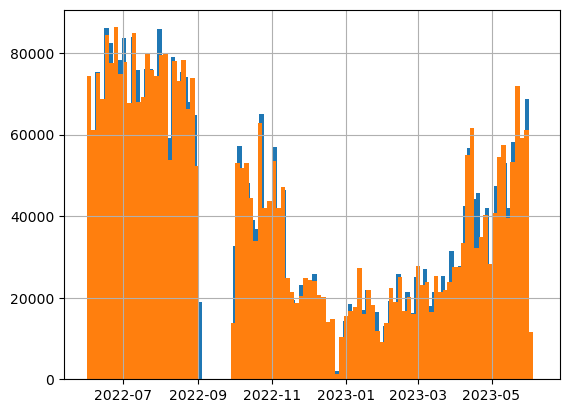

In [3]:
%matplotlib inline
bins=100
df['start'].hist(bins=bins)
df['stop'].hist(bins=bins)

That's weird; where's the September 2022 data?

In [4]:
df.dtypes

ride_id                           object
member_casual                     object
startdate                         object
starttime                         object
stopdate                          object
stoptime                          object
rideable_type                     object
tripduration                       int64
max_temperature_c                  int64
min_temperature_c                  int64
temperature_morning_c              int64
temperature_noon_c                 int64
temperature_evening_c              int64
temperature_night_c                int64
precip_total_day_mm              float64
windspeed_max_kmh                  int64
cloudcover_avg_percent           float64
start                     datetime64[ns]
stop                      datetime64[ns]
dtype: object

We know our data is unbalanced in member/casual and rideable type; how unbalanced is it?

<Axes: >

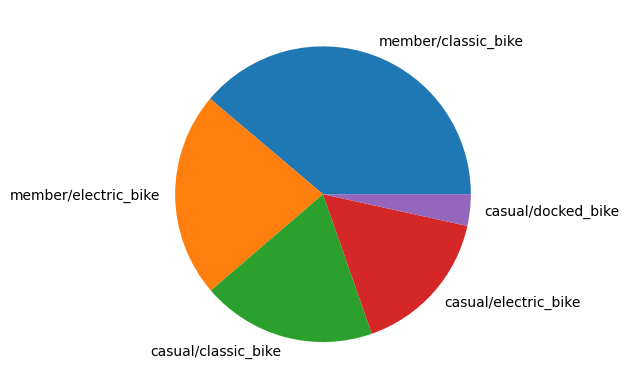

In [5]:
(df['member_casual'] + '/' + df['rideable_type']).value_counts().plot.pie()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: xlabel='start', ylabel='tripduration'>

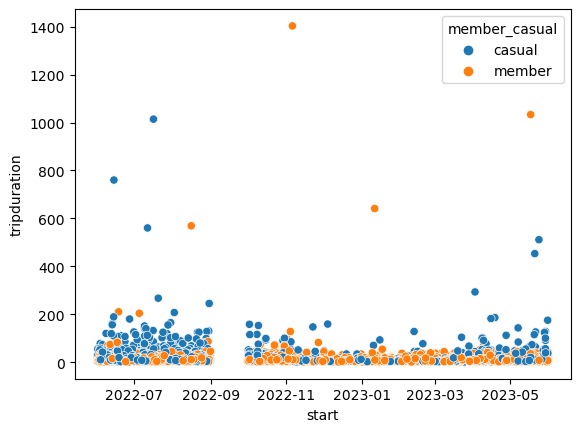

In [6]:
from seaborn import scatterplot
scatterplot(data=df.sample(5000), x='start', y='tripduration', hue='member_casual')

Let's get ready to model. We want to predict trip duration, so we don't want to include both the start and end times.

In [7]:
model_columns = ['member_casual', 'rideable_type',  'max_temperature_c',
       'min_temperature_c', 'temperature_morning_c', 'temperature_noon_c',
       'temperature_evening_c', 'temperature_night_c', 'precip_total_day_mm',
       'windspeed_max_kmh', 'cloudcover_avg_percent', 'start', 'tripduration',]
model_df = df[model_columns].copy(deep=True)
model_df.sample(5)

,member_casual,rideable_type,max_temperature_c,min_temperature_c,temperature_morning_c,temperature_noon_c,temperature_evening_c,temperature_night_c,precip_total_day_mm,windspeed_max_kmh,cloudcover_avg_percent,start,tripduration
1314279,member,classic_bike,22,14,15,22,21,15,0.1,13,31.125,2023-05-30 07:30:13,13
412333,member,classic_bike,33,22,22,32,31,23,0.1,10,13.250,2022-07-22 16:42:55,35
647259,member,electric_bike,30,19,19,29,28,20,0.0,12,0.000,2022-08-05 19:58:55,3
77432,casual,electric_bike,30,20,20,27,27,22,1.2,19,49.125,2022-08-25 23:35:58,21
721719,casual,classic_bike,20,13,13,19,20,14,0.0,10,29.125,2022-06-07 07:30:38,15


It's called we do some feature engineering

In [8]:
model_df['year'] = model_df['start'].dt.year
model_df['month'] = model_df['start'].dt.month
model_df['day'] = model_df['start'].dt.day
model_df['day_of_week'] = model_df['start'].dt.day_of_week
model_df['hour_of_day'] = model_df['start'].dt.hour
model_df = pd.get_dummies(data=model_df.drop(columns=['start']), columns=['member_casual', 'rideable_type'])
model_df.sample(5)

,max_temperature_c,min_temperature_c,temperature_morning_c,temperature_noon_c,temperature_evening_c,temperature_night_c,precip_total_day_mm,windspeed_max_kmh,cloudcover_avg_percent,tripduration,year,month,day,day_of_week,hour_of_day,member_casual_casual,member_casual_member,rideable_type_classic_bike,rideable_type_docked_bike,rideable_type_electric_bike
35326,26,21,22,22,26,23,8.3,18,59.25,20,2022,8,28,6,13,1,0,1,0,0
270249,10,-4,4,2,1,10,3.0,37,83.75,2,2023,3,17,4,13,0,1,1,0,0
1422780,18,16,16,16,16,16,2.3,9,72.75,7,2022,6,10,4,10,0,1,0,0,1
1350839,11,2,2,7,10,3,0.0,28,17.75,7,2022,10,19,2,21,0,1,0,0,1
1094343,13,7,7,11,13,9,0.0,19,14.75,3,2022,10,15,5,19,0,1,0,0,1


In [9]:
model_df.dtypes

max_temperature_c                int64
min_temperature_c                int64
temperature_morning_c            int64
temperature_noon_c               int64
temperature_evening_c            int64
temperature_night_c              int64
precip_total_day_mm            float64
windspeed_max_kmh                int64
cloudcover_avg_percent         float64
tripduration                     int64
year                             int64
month                            int64
day                              int64
day_of_week                      int64
hour_of_day                      int64
member_casual_casual             uint8
member_casual_member             uint8
rideable_type_classic_bike       uint8
rideable_type_docked_bike        uint8
rideable_type_electric_bike      uint8
dtype: object

<Axes: >

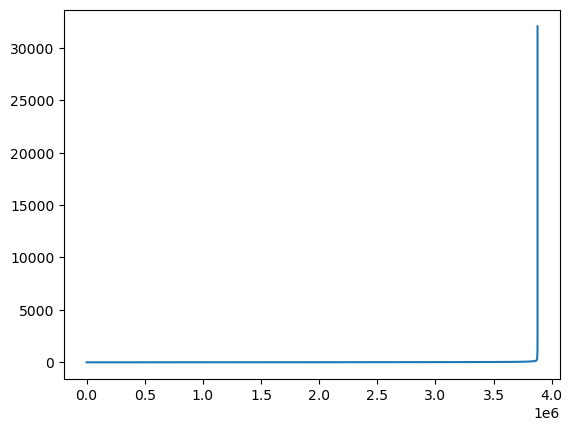

In [10]:
# does our outcome have a particular shape?
model_df.sort_values(by=['tripduration']).reset_index()['tripduration'].plot()

In [11]:
# we have outliers; what do they look like?
model_df.sort_values(by=['tripduration']).reset_index().tail(20)['tripduration']

3877882     1493
3877883     1496
3877884     1497
3877885     1497
3877886     1497
3877887     1497
3877888     1498
3877889     1767
3877890     2285
3877891     2349
3877892     2648
3877893     2719
3877894     3245
3877895     4848
3877896     6672
3877897     8243
3877898     9962
3877899    10807
3877900    12136
3877901    32035
Name: tripduration, dtype: int64

<Axes: >

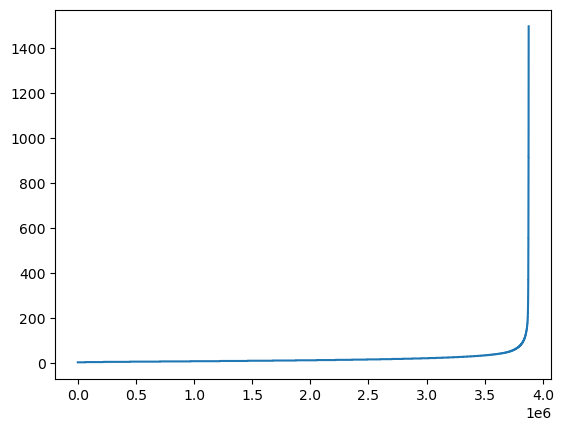

In [12]:
# first let's trim our outliers; we're not going to try to predict anything over 1500 unites
model_df = model_df[model_df['tripduration'] < 1500]
model_df.sort_values(by=['tripduration']).reset_index()['tripduration'].plot()

<Axes: >

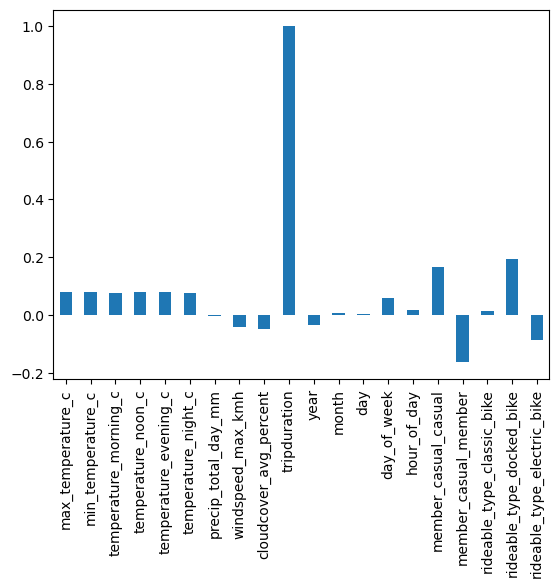

In [13]:
# before we go any further let's look at our correlations
model_df.corr()['tripduration'].plot(kind='bar')

There's essentially no signal in our weather variables.

In [14]:
# now let's train/test split so we can train a model
from sklearn.model_selection import train_test_split
random_state = 1
test_size = 0.1
x_train, x_test, y_train, y_test = train_test_split(model_df.drop(columns=['tripduration']).values, model_df['tripduration'], test_size=test_size, random_state=random_state)
print(type(x_train), len(x_train))

<class 'numpy.ndarray'> 3490100


In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

model = DecisionTreeRegressor()
model.fit(X=x_train, y=y_train)
y_pred = model.predict(X=x_test)
r2_score(y_true=y_test, y_pred=y_pred)

0.04689756424094682

<Axes: xlabel='test', ylabel='pred'>

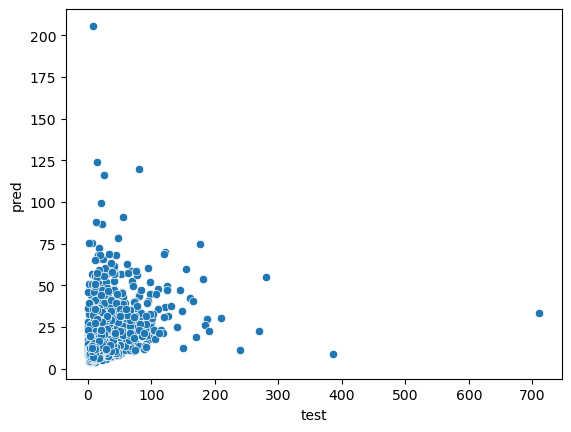

In [16]:
from seaborn import scatterplot
scatterplot(data=pd.DataFrame(data={'test': y_test, 'pred': y_pred}).sample(5000), x='test', y='pred',)

Yikes. It looks like this data does not predict trip duration. Let's look for something else.

<Axes: xlabel='rideable_type', ylabel='cloudcover_avg_percent'>

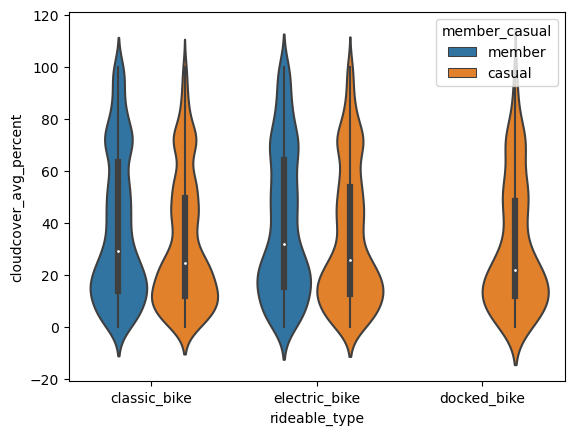

In [17]:
from seaborn import violinplot
sample_size = 10000
# we want a member/casual balanced sample
sample_df = pd.concat([df[df['member_casual'] == 'member'].sample(sample_size // 2), df[df['member_casual'] == 'casual'].sample(sample_size // 2),]) 
violinplot(data=sample_df[['member_casual', 'rideable_type', 'cloudcover_avg_percent',]], y='cloudcover_avg_percent', x='rideable_type', hue='member_casual')

In [18]:
sample_df['rideable_type'].value_counts()

classic_bike     5711
electric_bike    3853
docked_bike       436
Name: rideable_type, dtype: int64

More rides occur on sunnier days regardless of rider or bike type.

<Axes: xlabel='rideable_type', ylabel='max_temperature_c'>

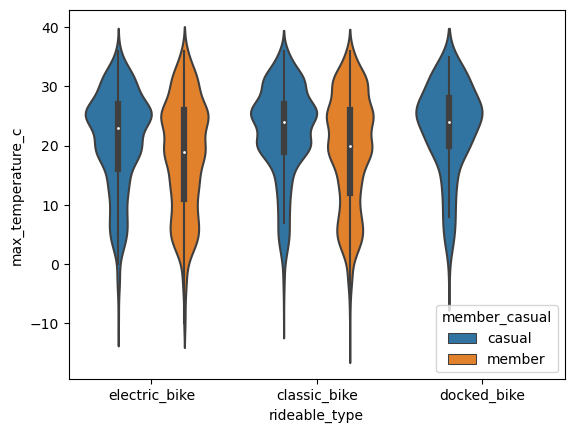

In [19]:
for column in ['max_temperature_c',
       'min_temperature_c', 'temperature_morning_c', 'temperature_noon_c',
       'temperature_evening_c', 'temperature_night_c', 'precip_total_day_mm',
       'windspeed_max_kmh']:
    pass

column  = 'max_temperature_c'
violinplot(data=df.sample(sample_size)[['member_casual', 'rideable_type', column,]], y=column, x='rideable_type', hue='member_casual')